In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

import numpy as np
np.random.seed(206)

import theano
import theano.tensor as tt
import pymc3 as pm

# Mean and Covariance Functions

A large set of mean and covariance functions are available in PyMC3.  It is relatively easy to define custom mean and covariance functions.  Since PyMC3 uses Theano, their gradients do not need to be defined by the user.  

## Mean functions

The following mean functions are available in PyMC3.

- `gp.mean.Zero`
- `gp.mean.Constant`
- `gp.mean.Linear`

All follow a similar usage pattern.  First, the mean function is specified.  Then it can be evaluated over some inputs.  The first two mean functions are very simple.  Regardless of the inputs, `gp.mean.Zero` returns a vector of zeros with the same length as the number of input values.

### Zero

In [2]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())

[0. 0. 0. 0. 0.]


The default mean functions for all GP implementations in PyMC3 is `Zero`.

### Constant

`gp.mean.Constant` returns a vector whose value is provided.

In [3]:
const_func = pm.gp.mean.Constant(25.2)

print(const_func(X).eval())

[25.2 25.2 25.2 25.2 25.2]


As long as the shape matches the input it will receive, `gp.mean.Constant` can also accept a Theano tensor or vector of PyMC3 random variables.

In [4]:
const_func_vec = pm.gp.mean.Constant(tt.ones(5))

print(const_func_vec(X).eval())

[1. 1. 1. 1. 1.]


### Linear

`gp.mean.Linear` is a takes as input a matrix of coefficients and a vector of intercepts (or a slope and scalar intercept in one dimension).

In [5]:
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())

[-0.36242716  2.20718024  0.41039522  2.50735445 -2.06177178]


## Defining a custom mean function

To define a custom mean function, subclass `gp.mean.Mean`, and provide `__call__` and `__init__` methods.  For example, the code for the `Constant` mean function is

```python
import theano.tensor as tt

class Constant(pm.gp.mean.Mean):
    
    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c 

    def __call__(self, X): 
        return tt.alloc(1.0, X.shape[0]) * self.c

```

Remember that Theano must be used instead of NumPy.

## Covariance functions

PyMC3 contains a much larger suite of built-in covariance functions.  The following shows functions drawn from a GP prior with a given covariance function, and demonstrates how composite covariance functions can be constructed with Python operators in a straightforward manner.  Our goal was for our API to follow kernel algebra (see Ch.4 of Rassmussen + Williams) as closely as possible.  See the main documentation page for an overview on their usage in PyMC3.  

### Exponentiated Quadratic

$$
k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]
$$

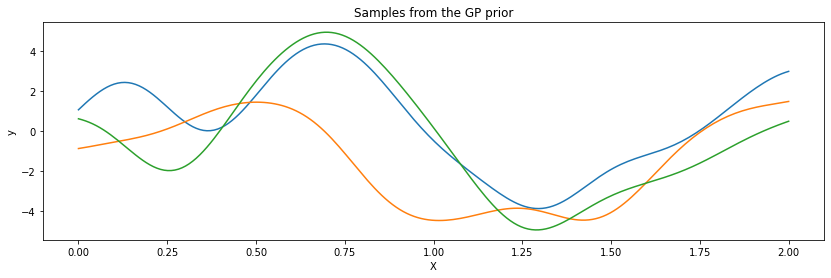

In [6]:
lengthscale = 0.2 
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Two (and higher) Dimensional Inputs

#### Both dimensions active

It is easy to define kernels with higher dimensional inputs.  Notice that the ```ls``` (lengthscale) parameter is an array of length 2.  Lists of PyMC3 random variables can be used for automatic relevance determination (ARD).

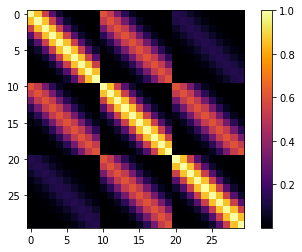

In [7]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

#### One dimension active

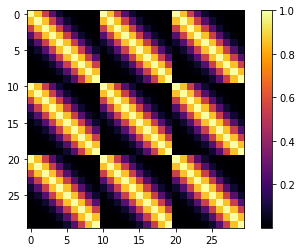

In [8]:
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

#### Product of covariances over different dimensions

Note that this is equivalent to using a two dimensional `ExpQuad` with separate lengthscale parameters for each dimension.

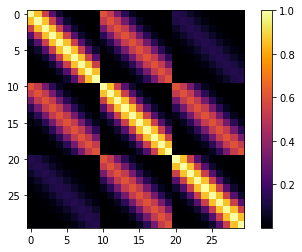

In [9]:
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

### White Noise

$$
k(x, x') = \sigma^2 \mathrm{I}_{xx}
$$

/env/miniconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


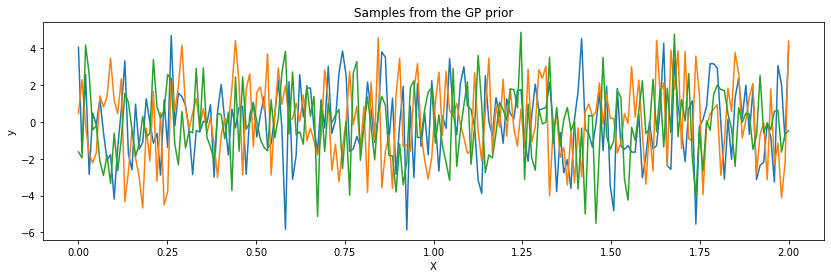

In [10]:
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Constant

$$
k(x, x') = c
$$

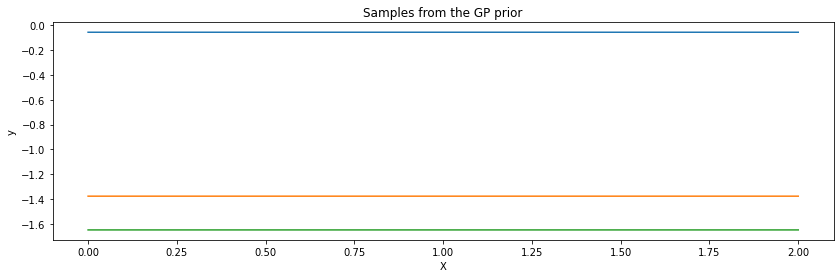

In [11]:
c = 2.0
cov = pm.gp.cov.Constant(c)
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Rational Quadratic

$$
k(x, x') = \left(1 + \frac{(x - x')^2}{2\alpha\ell^2} \right)^{-\alpha}
$$

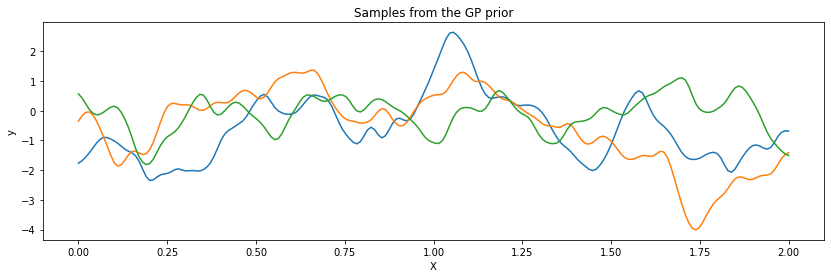

In [12]:
alpha = 0.1
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.RatQuad(1, ls, alpha)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Exponential

$$
k(x, x') = \mathrm{exp}\left[ -\frac{||x - x'||}{2\ell^2} \right]
$$

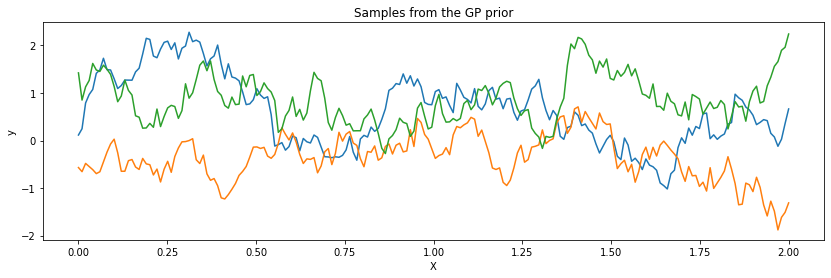

In [13]:
inverse_lengthscale = 5
cov = pm.gp.cov.Exponential(1, ls_inv=inverse_lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Matern 5/2

$$
k(x, x') = \left(1 + \frac{\sqrt{5(x - x')^2}}{\ell} +
            \frac{5(x-x')^2}{3\ell^2}\right)
            \mathrm{exp}\left[ - \frac{\sqrt{5(x - x')^2}}{\ell} \right]
$$

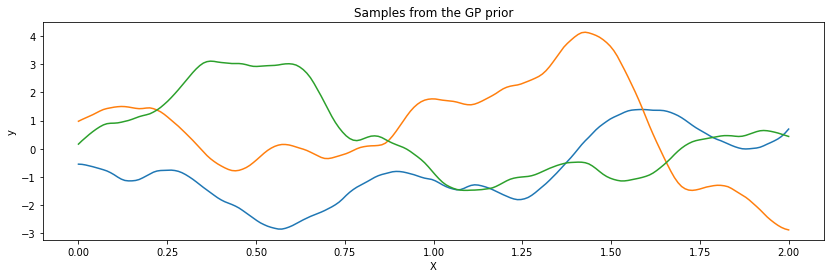

In [14]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern52(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Matern 3/2

$$
k(x, x') = \left(1 + \frac{\sqrt{3(x - x')^2}}{\ell}\right)
           \mathrm{exp}\left[ - \frac{\sqrt{3(x - x')^2}}{\ell} \right]
$$

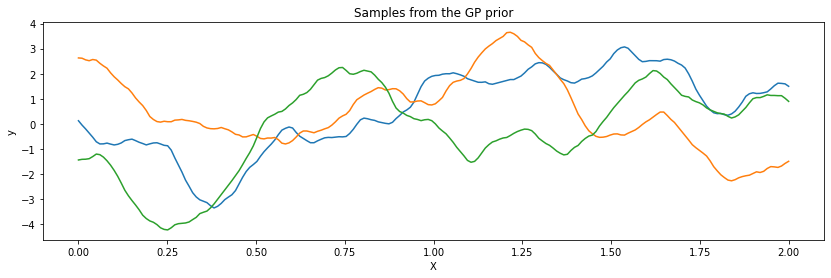

In [15]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern32(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Matern 1/2

$$k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{\ell} \right]$$

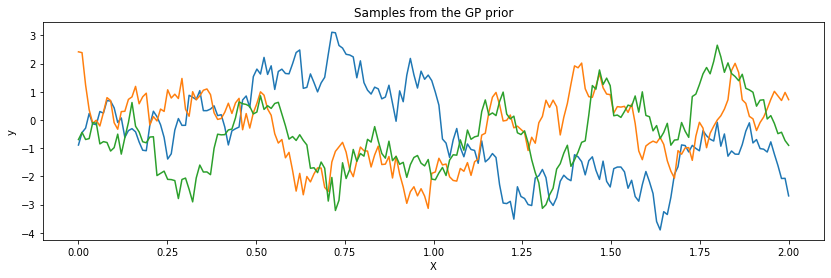

In [16]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern12(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Cosine

$$
k(x, x') = \mathrm{cos}\left( 2 \pi \frac{||x - x'||}{ \ell^2} \right)
$$

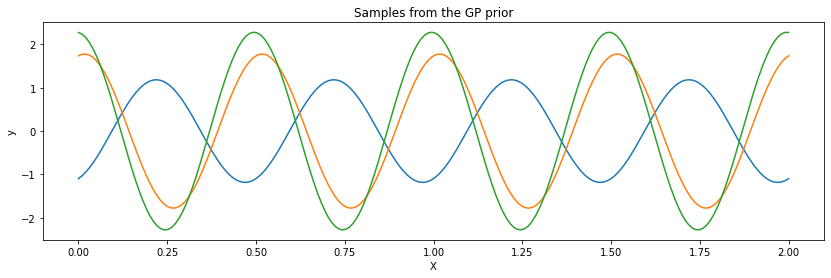

In [17]:
period = 0.5
cov = pm.gp.cov.Cosine(1, period)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Linear

$$
k(x, x') = (x - c)(x' - c)
$$

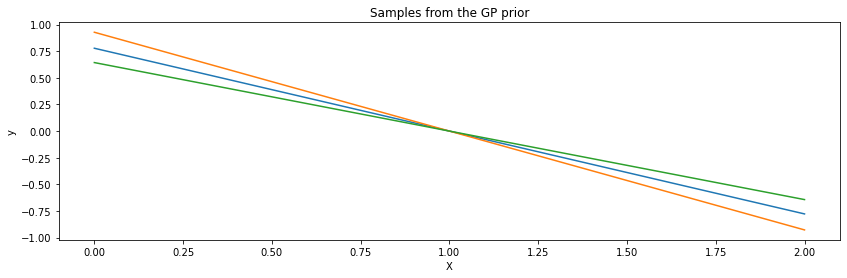

In [18]:
c = 1.0
tau = 2.0
cov = tau * pm.gp.cov.Linear(1, c)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Polynomial

$$
k(x, x') = [(x - c)(x' - c) + \mathrm{offset}]^{d}
$$

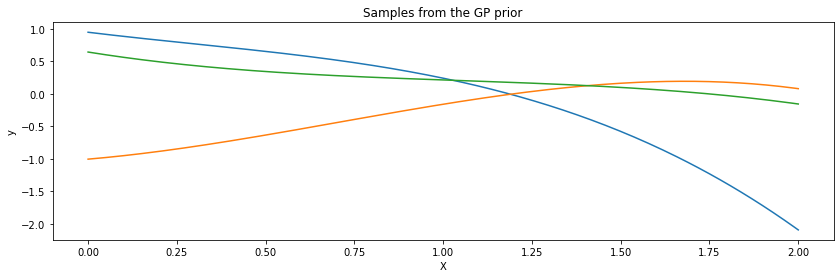

In [19]:
c = 1.0
d = 3
offset = 1.0
tau = 0.1
cov = tau * pm.gp.cov.Polynomial(1, c=c, d=d, offset=offset)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Multiplication with a precomputed covariance matrix

A covariance function ```cov``` can be multiplied with numpy matrix, ```K_cos```, as long as the shapes are appropriate.

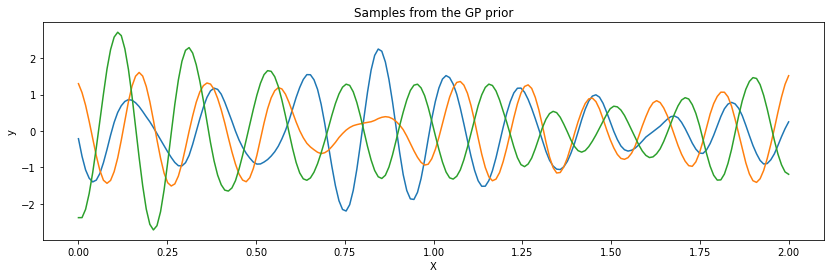

In [20]:
# first evaluate a covariance function into a matrix
period = 0.2
cov_cos = pm.gp.cov.Cosine(1, period)
K_cos = theano.function([], cov_cos(X))()

# now multiply it with a covariance *function* 
cov = pm.gp.cov.Matern32(1, 0.5) * K_cos
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The first argument of the warping function must be the input ```X```.  The remaining arguments can be anything else, including random variables.  

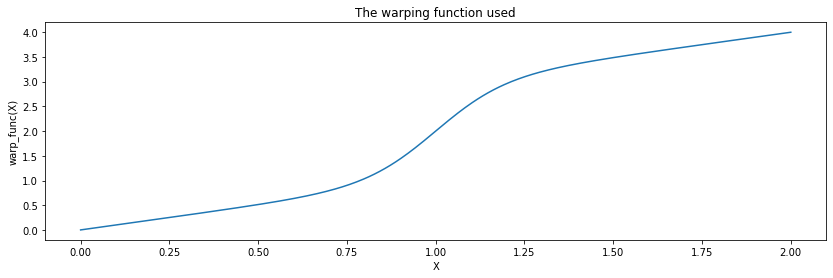

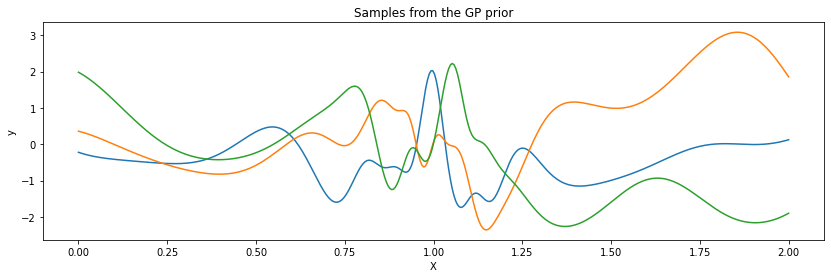

In [21]:
def warp_func(x, a, b, c):
    return 1.0 + x + (a * tt.tanh(b * (x - c)))

a = 1.0
b = 5.0
c = 1.0

cov_exp = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_exp)

X = np.linspace(0, 2, 400)[:,None]
wf = warp_func(X.flatten(), a,b,c).eval()

plt.figure(figsize=(14,4))
plt.plot(X, wf); plt.xlabel("X"); plt.ylabel("warp_func(X)"); 
plt.title("The warping function used");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Constructing `Periodic` using `WarpedInput`

The `WarpedInput` kernel can be used to create the `Periodic` covariance.  This covariance models functions that are periodic, but are not an exact sine wave (like the `Cosine` kernel is).

The periodic kernel is given by

$$
k(x, x') = \exp\left( -\frac{2 \sin^{2}(\pi |x - x'|\frac{1}{T})}{\ell^2}     \right)
$$

Where T is the period, and $\ell$ is the lengthscale.  It can be derived by warping the input of an `ExpQuad` kernel with the function $\mathbf{u}(x) = (\sin(2\pi x \frac{1}{T})\,, \cos(2 \pi x \frac{1}{T}))$.  Here we use the `WarpedInput` kernel to construct it.

The input `X`, which is defined at the top of this page, is 2 "seconds" long.  We use a period of $0.5$, which means that functions
drawn from this GP prior will repeat 4 times over 2 seconds.  

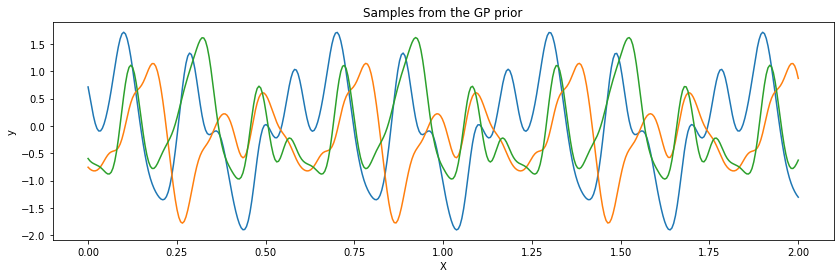

In [22]:
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
    return u

T = 0.6
ls = 0.4
# note that the input of the covariance function taking 
#    the inputs is 2 dimensional 
cov_exp = pm.gp.cov.ExpQuad(2, ls)  
cov = pm.gp.cov.WarpedInput(1, cov_func=cov_exp, 
                               warp_func=mapping, args=(T, ))

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Periodic

There is no need to construct the periodic covariance this way every time.  A more efficient implementation of this covariance function is built in.

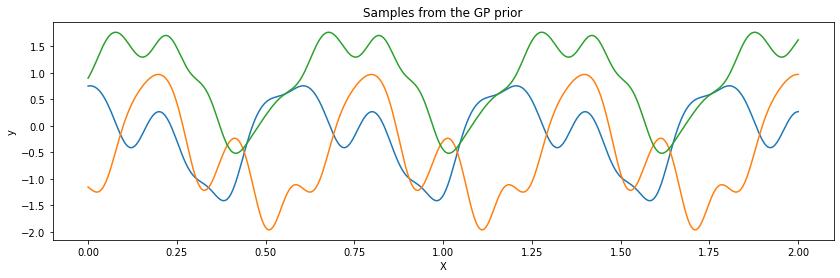

In [23]:
period = 0.6
ls = 0.4
cov = pm.gp.cov.Periodic(1, period=period, ls=ls) 

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Gibbs

The Gibbs covariance function applies a positive definite warping function to the lengthscale.  Similarly to ```WarpedInput```, the lengthscale warping function can be specified with parameters that are either fixed or random variables.

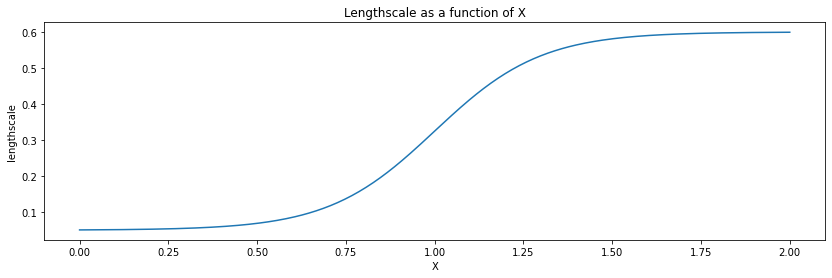

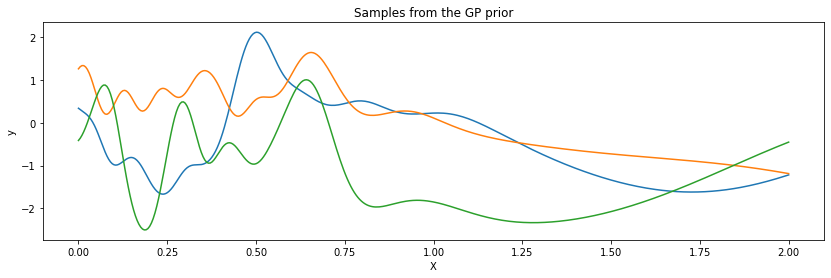

In [24]:
def tanh_func(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2.0 - (ls1 - ls2) / 2.0 * tt.tanh((x - x0) / w)

ls1 = 0.05
ls2 = 0.6
w = 0.3
x0 = 1.0
cov = pm.gp.cov.Gibbs(1, tanh_func, args=(ls1, ls2, w, x0))
    
wf = tanh_func(X, ls1, ls2, w, x0).eval()
plt.figure(figsize=(14,4))
plt.plot(X, wf); plt.ylabel("lengthscale"); plt.xlabel("X"); plt.title("Lengthscale as a function of X");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Scaled Covariance

One can construct a new kernel or covariance function by multiplying some base kernel by a nonnegative function $\phi(x)$,

$$
k_{\mathrm{scaled}}(x, x') = \phi(x) k_{\mathrm{base}}(x, x') \phi(x') \,.
$$

This is useful for specifying covariance functions whose amplitude changes across the domain.  

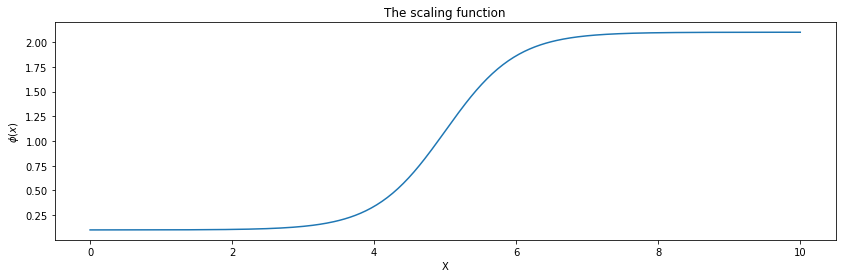

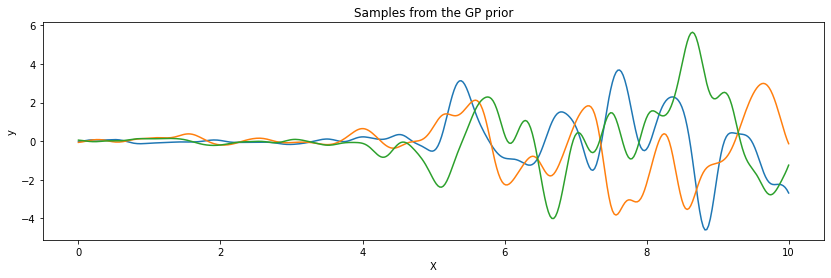

In [25]:
def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * pm.math.invlogit(a*(x - x0)) + c


a = 2.0
x0 = 5.0
c = 0.1
d = 2.0

cov_base = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a,x0,c,d), cov_func=cov_base)

X = np.linspace(0, 10, 400)[:,None]
lfunc = logistic(X.flatten(), a, b, c, d).eval()

plt.figure(figsize=(14,4))
plt.plot(X, lfunc); plt.xlabel("X"); plt.ylabel("$\phi(x)$"); 
plt.title("The scaling function");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Constructing a Changepoint kernel using `ScaledCov`

The `ScaledCov` kernel can be used to create the `Changepoint` covariance.  This covariance models 
a process that gradually transitions from one type of behavior to another.

The changepoint kernel is given by

$$
k(x, x') = \phi(x)k_{1}(x, x')\phi(x)  + (1 - \phi(x))k_{2}(x, x')(1 - \phi(x'))
$$

where $\phi(x)$ is the logistic function.

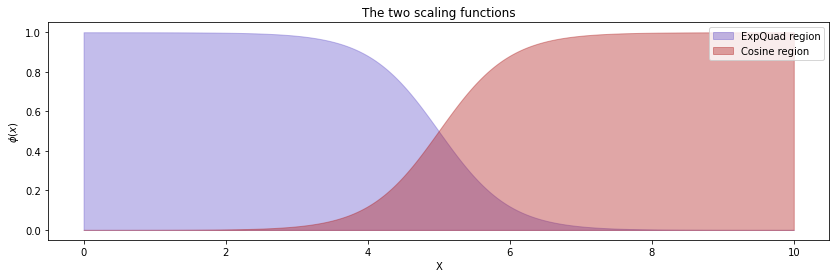

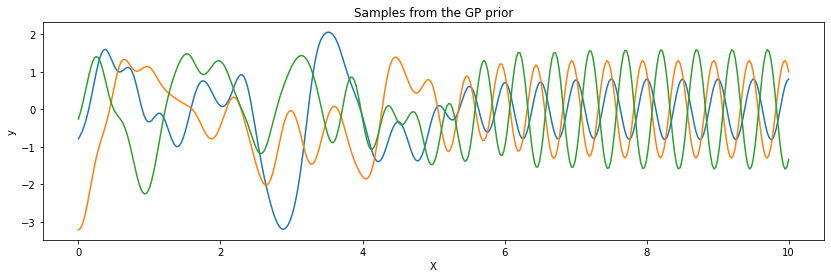

In [26]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a*(x - x0))


a = 2.0
x0 = 5.0

cov1 = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(-a, x0), 
                           cov_func=pm.gp.cov.ExpQuad(1, 0.2))
cov2 = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a, x0), 
                           cov_func=pm.gp.cov.Cosine(1, 0.5))
cov = cov1 + cov2

X = np.linspace(0, 10, 400)
plt.figure(figsize=(14,4))
plt.fill_between(X, np.zeros(400), logistic(X, -a, x0).eval(), label="ExpQuad region", 
                 color="slateblue", alpha=0.4); 
plt.fill_between(X, np.zeros(400), logistic(X,  a, x0).eval(), label="Cosine region", 
                 color="firebrick", alpha=0.4); 
plt.legend();
plt.xlabel("X"); plt.ylabel("$\phi(x)$"); 
plt.title("The two scaling functions");

K = cov(X[:,None]).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Combination of two or more Covariance functions

You can combine different covariance functions to model complex data.

In particular, you can perform the following operations on any covaraince functions:

- Add other covariance function with equal or broadcastable dimensions with first covariance function
- Multiply with a scalar or a covariance function with equal or broadcastable dimensions with first covariance function
- Exponentiate with a scalar.

#### Addition

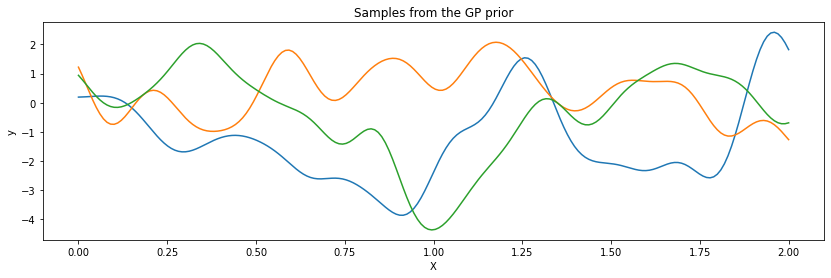

In [27]:
ls_1 = .1
tau_1 = 2.
ls_2 = 0.5
tau_2 = 1.
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

cov = cov_1 + cov_2

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

#### Multiplication

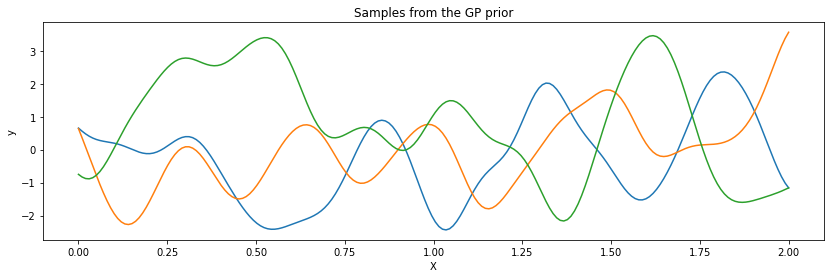

In [28]:
ls_1 = .1
tau_1 = 2.
ls_2 = 0.5
tau_2 = 1.
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)
cov_2 = tau_2 * pm.gp.cov.ExpQuad(1, ls=ls_2)

cov = cov_1 * cov_2

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

#### Exponentiation

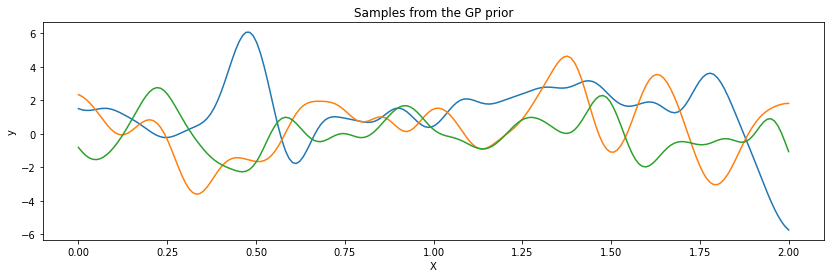

In [29]:
ls_1 = .1
tau_1 = 2.
power = 2
cov_1 = tau_1 * pm.gp.cov.ExpQuad(1, ls=ls_1)

cov = cov_1 ** power

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");

### Defining a custom covariance function

Covariance function objects in PyMC3 need to implement the `__init__`, `diag`, and `full` methods, and subclass `gp.cov.Covariance`.  `diag` returns only the diagonal of the covariance matrix, and `full` returns the full covariance matrix.  The `full` method has two inputs `X` and `Xs`.  `full(X)` returns the square covariance matrix, and `full(X, Xs)` returns the cross-covariances between the two sets of inputs.

For example, here is the implementation of the `WhiteNoise` covariance function:

```python
class WhiteNoise(pm.gp.cov.Covariance):
    def __init__(self, sigma):
        super(WhiteNoise, self).__init__(1, None)
        self.sigma = sigma

    def diag(self, X):
        return tt.alloc(tt.square(self.sigma), X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])
```

If we have forgotten an important covariance or mean function, please feel free to submit a pull request!

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

theano 1.0.4
pymc3  3.9.0
numpy  1.18.5
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
